# **Predicting Chest Pain Type from Health Data**

## **Introduction**

Heart disease refers to a group of conditions that affect the heart. As one of the leading causes of death in North America, early diagnosis is crucial to help save lives. Interestingly, chest pain type is linked to heart disease type, thus, classifying chest pain type may be effective in diagnosing heart diseases. Using patients' recorded health data, we will classify chest pain into three categories (anginal, non-anginal, or asymptomatic) to answer the question: How are resting blood pressure, age, and maximum heart rate achieved related to a patient's chest pain type, and how accurately can a patient's chest pain type be predicted with these data? We are using the Heart Disease dataset, containing observations linked to heart diseases, to answer our question. The dataset includes data from Cleveland, Hungary, Switzerland, and VA Long Beach, which we combined into a single data frame.

#### **Abbreviations**
- **KNN:** K-nearest neighbours

## **Data Analysis**

### **Methods**

#### Data Analysis Methods:
Our objective is to classify a person's chest paint type based on their resting blood pressure, age, and maximum heart rate achieved. These variables were chosen as predictors for their distinct quantitative characteristics. Our classifier, which encompasses data preprocessing, model training, and class prediction, will utilize a K-nearest neighbours classification model. Given the absence of a distinct chest pain type of interest, the primary performance metric we will use to evaluate our classifier is accuracy (rather than precision and recall). To maximize classifier performance (i.e., increase accuracy), we will choose the optimal value for K by tuning our model and incorporate cross-validation.


#### Visualizing Our Results:
To visualize how KNN uses distance to classify new observations, we will create annotated scatter plots of our predictor variables with observations coloured by class (and the observation of interest circled). Then, to show how KNN determines class by majority rule, we will create a bar graph showing the number of the observation of interest's neighbours that belong to each class. Finally, to visualize the tuning process, we will produce an accuracy estimate vs. K value line plot, illustrating which K value resulted in the greatest accuracy estimate.

### **Data Reading/Wrangling/Cleaning**

In [1]:
library(tidyverse)
library(tidymodels)
library(RColorBrewer)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [2]:
options(repr.plot.width = 8, repr.plot.height = 8)

sws_url <- "https://raw.github.com/aaelbaz/DSCI-100-Group-Project/215e081060c7280c1d975721f1934d3c147aa8fe/heart_disease_data/processed.switzerland.data"
clv_url <- "https://raw.github.com/aaelbaz/DSCI-100-Group-Project/215e081060c7280c1d975721f1934d3c147aa8fe/heart_disease_data/processed.cleveland.data"
hgr_url <- "https://raw.github.com/aaelbaz/DSCI-100-Group-Project/215e081060c7280c1d975721f1934d3c147aa8fe/heart_disease_data/processed.hungarian.data"
vlb_url <- "https://raw.github.com/aaelbaz/DSCI-100-Group-Project/215e081060c7280c1d975721f1934d3c147aa8fe/heart_disease_data/processed.va.data"

cols <- c("age", "sex", "cp_type", "rest_bp", "cholesterol", "fbs", "rest_ecg", "max_hr",
          "exercise_angina", "st_depression", "st_slope", "coloured_vsls", "thal", "heart_disease")
na_vals <- c("", "NA", "?", -9.0)

sws <- read_csv(sws_url, col_names = cols, na = na_vals, show_col_types = FALSE) |> mutate(location = "Switzerland")
clv <- read_csv(clv_url, col_names = cols, na = na_vals, show_col_types = FALSE) |> mutate(location = "Cleveland")
hgr <- read_csv(hgr_url, col_names = cols, na = na_vals, show_col_types = FALSE) |> mutate(location = "Hungary")
vlb <- read_csv(vlb_url, col_names = cols, na = na_vals, show_col_types = FALSE) |> mutate(location = "VA Long Beach")

heart_disease_data <- bind_rows(sws, clv, hgr, vlb)

heart_disease_data$sex <- ifelse(heart_disease_data$sex == 0, "female", "male")
heart_disease_data$cp_type <- ifelse(heart_disease_data$cp_type == 1, "anginal",
                                     ifelse(heart_disease_data$cp_type == 2, "anginal",
                                            ifelse(heart_disease_data$cp_type == 3, "non-anginal", "asymptomatic")))
heart_disease_data$rest_ecg <- ifelse(heart_disease_data$rest_ecg == 0, "normal",
                                      ifelse(heart_disease_data$rest_ecg == 1, "abnormality", "hypertrophy"))
heart_disease_data$exercise_angina <- ifelse(heart_disease_data$exercise_angina == 0, "no", "yes")
heart_disease_data$st_slope <- ifelse(heart_disease_data$st_slope == 1, "upsloping",
                                      ifelse(heart_disease_data$st_slope == 2, "flat", "downsloping"))
heart_disease_data$thal <- ifelse(heart_disease_data$thal == 3, "normal",
                                      ifelse(heart_disease_data$thal == 6, "fixed", "reversable"))

heart_disease_data <- heart_disease_data |> mutate(sex = as.factor(sex), cp_type = as.factor(cp_type), fbs = as.factor(fbs), rest_ecg = as.factor(rest_ecg),
                                                   exercise_angina = as.factor(exercise_angina), st_slope = as.factor(st_slope), thal = as.factor(thal),
                                                   heart_disease = as.factor(heart_disease), location = as.factor(location))

head(heart_disease_data)

age,sex,cp_type,rest_bp,cholesterol,fbs,rest_ecg,max_hr,exercise_angina,st_depression,st_slope,coloured_vsls,thal,heart_disease,location
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>
32,male,anginal,95,0,NA,normal,127,no,0.7,upsloping,NA,NA,1,Switzerland
34,male,asymptomatic,115,0,NA,NA,154,no,0.2,upsloping,NA,NA,1,Switzerland
35,male,asymptomatic,NA,0,NA,normal,130,yes,NA,NA,NA,reversable,3,Switzerland
36,male,asymptomatic,110,0,NA,normal,125,yes,1.0,flat,NA,fixed,1,Switzerland
38,female,asymptomatic,105,0,NA,normal,166,no,2.8,upsloping,NA,NA,2,Switzerland
38,female,asymptomatic,110,0,0,normal,156,no,0.0,flat,NA,normal,1,Switzerland


To work with the data, we will first perform data-wrangling tasks in order to narrow down our focus on the variables of interest. To do this, we will first select the class variable: cy_type, as well as the three of our predictor variables. In order for the k-nearest neighbour classifying model to work, the observations with NA appearing in any of the predictor variables will be removed. The removal of values containing NA values might affect our result in a way that some important trends and information could be lost. For instance, the observation of a missing value for resting blood pressure might provide significant information for another predictor. However, the amount of NA values is relatively small compared to the values that we will retain. Meaning that the effect would not be significant.

In [3]:
heart_disease_clean <- heart_disease_data |>
    select(age, cp_type, rest_bp, max_hr)|>
    filter(!is.na(rest_bp),
           !is.na(age),
           !is.na(cp_type),
           !is.na(max_hr))
head(heart_disease_clean)

age,cp_type,rest_bp,max_hr
<dbl>,<fct>,<dbl>,<dbl>
32,anginal,95,127
34,asymptomatic,115,154
36,asymptomatic,110,125
38,asymptomatic,105,166
38,asymptomatic,110,156
38,non-anginal,100,179


To create our model of classification using this heart disease data set, we will first be splitting the data set into a training set and a test set. We will create and tune our model with the training set and test the performance of our model on the testing set. 

In [4]:
set.seed(1234)

heart_disease_split <- initial_split(heart_disease_clean, prop = 0.75, strata = cp_type)  
heart_disease_train <- training(heart_disease_split)   
heart_disease_test <- testing(heart_disease_split)

### **Exploratory Data Analysis**

In [5]:
cp_type_summarize <- heart_disease_train |> group_by(cp_type) |>
                        summarize(avg_rest_bp = mean(rest_bp, na.rm = TRUE),
                                  avg_max_hr = mean(max_hr, na.rm = TRUE),
                                  avg_age = mean(age, na.rm = TRUE),
                                  num_cases = n())

cp_type_summarize

cp_type,avg_rest_bp,avg_max_hr,avg_age,num_cases
<fct>,<dbl>,<dbl>,<dbl>,<int>
anginal,132.3333,149.3718,49.91667,156
asymptomatic,131.7829,128.3229,54.57714,350
non-anginal,132.8478,144.1377,52.93478,138


This table illustrates distinct differences (although subtle) in average resting blood pressure, maximum heart rate achieved, and age between chest pain types (also showing number of cases from each class). Having multiple predictors with distinct values between classes increases the likelihood of accurate class prediction.

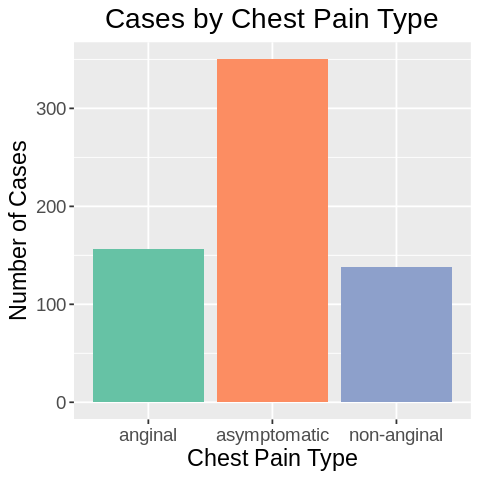

In [6]:
options(repr.plot.width = 4, repr.plot.height= 4)

class_plot <- ggplot(heart_disease_train, aes(x = cp_type, fill = cp_type)) + 
                geom_bar(show.legend = FALSE) +
                labs(x= "Chest Pain Type", y= "Number of Cases") +
                ggtitle("Cases by Chest Pain Type") +
                scale_fill_brewer(palette = "Set2") +
                theme(text = element_text(size = 14), plot.title = element_text(hjust = 0.5))
class_plot

This graph shows the imbalance in number of cases of each chest pain type (which will inform our data preprocessing). Anginal and non-anginal cases are quite similar, however, the number of asymptomatic cases is notably larger; the number of anginal and non-anginal cases (individually) are about 40% of the asymptomatic cases.

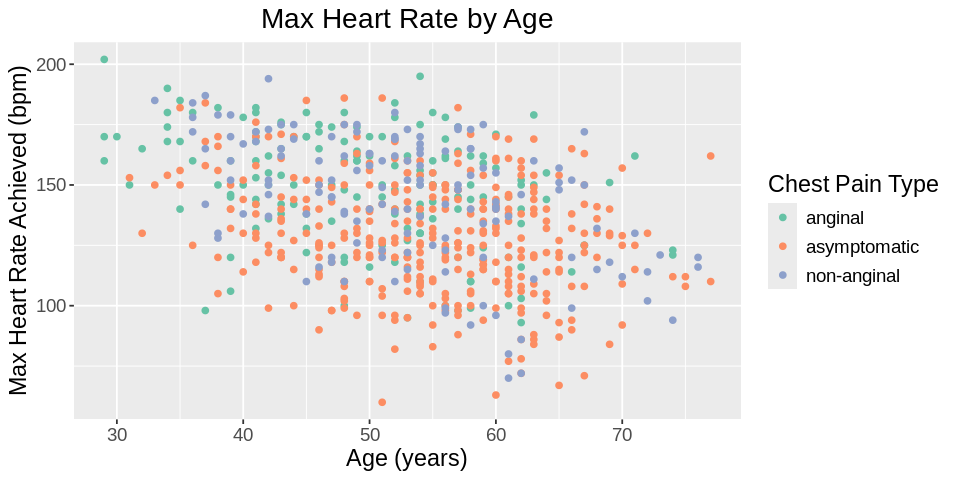

In [7]:
options(repr.plot.width = 8, repr.plot.height= 4)

heart_plot <- heart_disease_train |>
    ggplot(aes(x = age, y = max_hr, color = cp_type)) +
    geom_point() +
    labs(x = "Age (years)", y = "Max Heart Rate Achieved (bpm)", color = "Chest Pain Type") +
    ggtitle("Max Heart Rate by Age") +
    scale_color_brewer(palette = "Set2") +
    theme(text = element_text(size = 14), plot.title = element_text(hjust = 0.5))

suppressWarnings(print(heart_plot))

This plot shows the relationship between max heart rate achieved and age with observations coloured by class to demonstrate the distribution of classes by these predictors. Unfortunately, given the significant overlap in observation coordinate ranges between classes, classes do not seem highly distinguishable by max heart rate achieved and age.

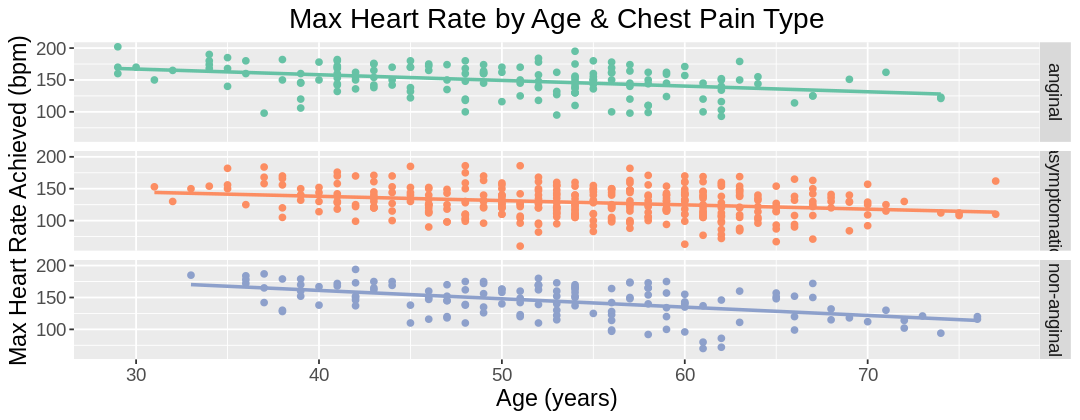

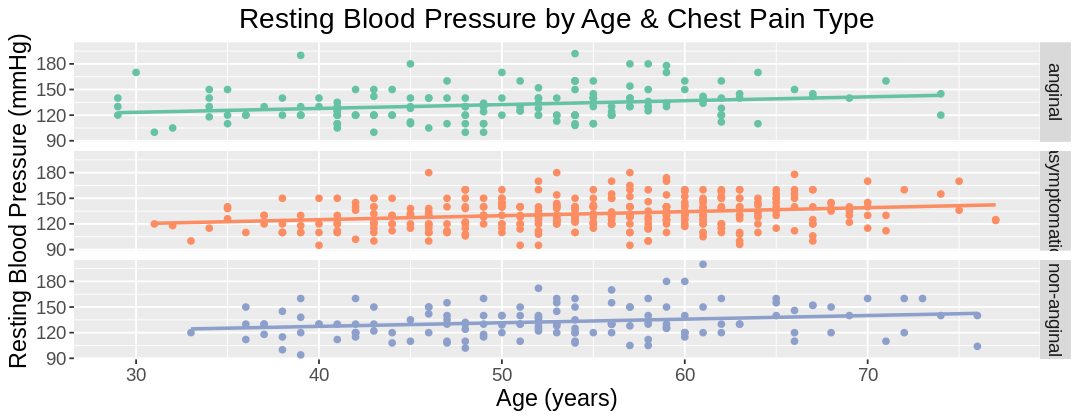

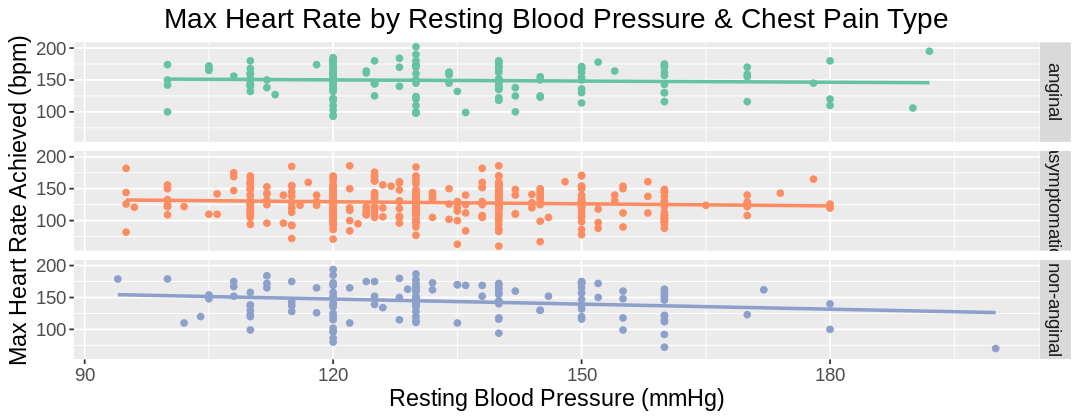

In [8]:
options(repr.plot.width = 9, repr.plot.height = 3.5)

hr_age_plot <- ggplot(heart_disease_train, aes(x = age, y = max_hr, color = cp_type)) +
                geom_point(show.legend = FALSE) +
                labs(x = "Age (years)", y = "Max Heart Rate Achieved (bpm)", color = "Chest Pain Type") +
                ggtitle("Max Heart Rate by Age & Chest Pain Type") +
                facet_grid(rows = vars(cp_type)) +
                geom_smooth(method = "lm", se = FALSE, formula = y ~ x, show.legend = FALSE) +
                scale_color_brewer(palette = "Set2") +
                theme(text = element_text(size = 14), plot.title = element_text(hjust = 0.5))
suppressWarnings(print(hr_age_plot))

bp_age_plot <- ggplot(heart_disease_train, aes(x = age, y = rest_bp, color = cp_type)) +
                geom_point(show.legend = FALSE) +
                labs(x = "Age (years)", y = "Resting Blood Pressure (mmHg)", color = "Chest Pain Type") +
                ggtitle("Resting Blood Pressure by Age & Chest Pain Type") +
                facet_grid(rows = vars(cp_type)) +
                geom_smooth(method = "lm", se = FALSE, formula = y ~ x, show.legend = FALSE) +
                scale_color_brewer(palette = "Set2") +
                theme(text = element_text(size = 14), plot.title = element_text(hjust = 0.5))
suppressWarnings(print(bp_age_plot))

hr_bp_plot <- ggplot(heart_disease_train, aes(x = rest_bp, y = max_hr, color = cp_type)) +
                geom_point(show.legend = FALSE) +
                labs(x = "Resting Blood Pressure (mmHg)", y = "Max Heart Rate Achieved (bpm)", color = "Chest Pain Type") +
                ggtitle("Max Heart Rate by Resting Blood Pressure & Chest Pain Type") +
                facet_grid(rows = vars(cp_type)) +
                geom_smooth(method = "lm", se = FALSE, formula = y ~ x, show.legend = FALSE) +
                scale_color_brewer(palette = "Set2") +
                theme(text = element_text(size = 14), plot.title = element_text(hjust = 0.5))
suppressWarnings(print(hr_bp_plot))

These plots demonstrate the relationships between our predictor variables. Within each plot, the trends for each class are quite similar.

### **Classification & Classification Analysis**

Tuning the classifer is one of the most essential step in data analysis. Before we build our model, we will tune our model by choosing the best K value (number of nearest neighbor) using cross-validation and measuring the accuracy. The process of cross-validation using the function vfold_cv utilizes randomness. By setting a seed that is fixed for the rest of the data analysis, we will ensure that the analysis performed effectively uses randomness while maintaining reproducibility.

In [9]:
set.seed(1234)

heart_disease_recipe <- recipe(cp_type ~ rest_bp + age + max_hr, data = heart_disease_train) |>
                    step_scale(all_predictors()) |>
                    step_center(all_predictors())

knn_tune_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                set_engine("kknn") |>
                set_mode("classification")

heart_disease_vfold <- vfold_cv(heart_disease_train, v = 10, strata = cp_type)
k_vals <- tibble(neighbors = 1:50)

heart_disease_results <- workflow() |>
                            add_recipe(heart_disease_recipe) |>
                            add_model(knn_tune_spec) |>
                            tune_grid(resamples = heart_disease_vfold, grid = k_vals) |>
                            collect_metrics()

best_metrics_tbl <- heart_disease_results |>
                        filter(.metric == 'accuracy') |>
                        arrange(desc(mean)) |>
                        slice(1)

best_acc <- best_metrics_tbl |> select(mean) |> pull()
best_k <- best_metrics_tbl |> select(neighbors) |> pull()

k_acc_summary <- tibble(best_k = best_k, best_accuracy_percent = round((best_acc * 100), digits = 2))
k_acc_summary

best_k,best_accuracy_percent
<int>,<dbl>
22,56.97


After an optimal K value is chosen, we will be able to build our classification model using this K value as the number of nearest neighbor. To test the performance of this classification model, predictions were made on our testing data set and by comparing the predicted class and the actual class of chest pain type, the accuracy of our model was analyzed.  

In [10]:
knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
                    set_engine("kknn") |>
                    set_mode("classification")

heart_disease_best_fit <- workflow() |>
                            add_recipe(heart_disease_recipe) |>
                            add_model(knn_best_spec) |>
                            fit(heart_disease_train)

heart_disease_prediction_acc_est <- predict(heart_disease_best_fit, heart_disease_test) |>
                                            bind_cols(heart_disease_test) |>
                                            metrics(truth = cp_type, estimate = .pred_class) |>
                                            filter(.metric == "accuracy") |>
                                            select(.estimate) |>
                                            pull()

acc_est_percent <- paste(as.character(round((heart_disease_prediction_acc_est * 100), digits = 2)), "%", sep = "")
acc_est_percent

[1] "55.76%"

From model tuning we found that 22 neighbors produced the best accuracy. This is reflected in the below graph comparing the accuracies of models using 1-50 neighbors (the highest accuracy value appears at neighbors = 22). That being said, the below graph also demonstrates the overall innaccuracies of our model as for all k-values tested the accuracy is pretty low.

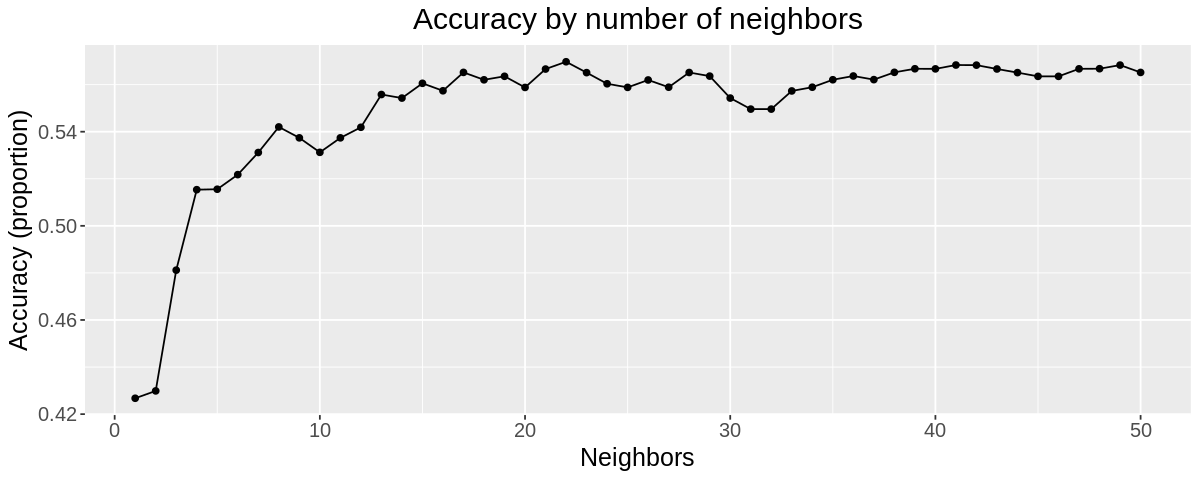

In [11]:
options(repr.plot.width = 10, repr.plot.height = 4)

k_vs_acc_plot <- heart_disease_results |>
                    filter(.metric == 'accuracy') |>
                    select(neighbors, mean) |>
                    ggplot(aes(x = neighbors, y = mean)) +
                        geom_point() +
                        geom_line() +
                        labs(x = "Neighbors", y = "Accuracy (proportion)") +
                        ggtitle("Accuracy by number of neighbors") +
                        theme(text= element_text(size =15), plot.title = element_text(hjust = 0.5))
k_vs_acc_plot

Predicted class vs. Actual Class 

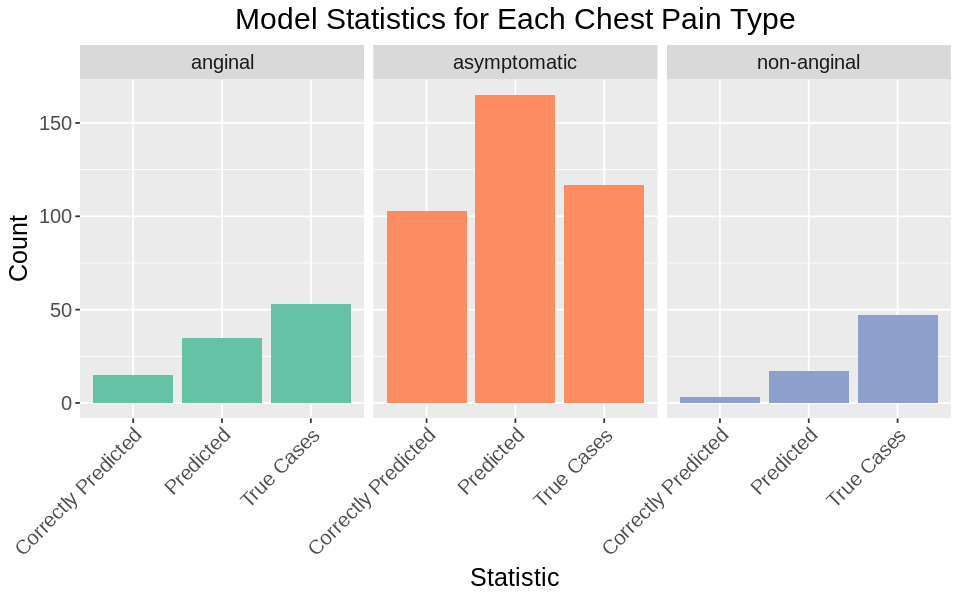

In [12]:
set.seed(1234)
options(repr.plot.width = 8, repr.plot.height = 5)


num_cases_test <- heart_disease_test |>
                    group_by(cp_type) |>
                    summarize(type = "True Cases", count = n())



predicted_class <- heart_disease_best_fit |>
    predict(heart_disease_test)


predicted_count <- predicted_class |>
                        mutate(cp_type = .pred_class)|>
                        group_by(cp_type) |>
                        summarize(type = "Predicted", count = n())

correct_predictions <- predicted_class |> 
                        bind_cols(heart_disease_test) |> 
                        select(.pred_class, cp_type) |> 
                        filter(cp_type == .pred_class) |>
                        group_by(cp_type) |>
                        summarize(type = "Correctly Predicted", count = n())



summary_tbl <- bind_rows(num_cases_test, predicted_count, correct_predictions)


summary_graph <- summary_tbl |>
                    ggplot(aes(x= type, y = count, fill = cp_type)) +
                        geom_bar(stat = "identity", show.legend = FALSE) +
                        ggtitle("Model Statistics for Each Chest Pain Type")+
                        labs(x = "Statistic", y = "Count") +
                        facet_grid(cols = vars(cp_type)) +
                        scale_fill_brewer(palette= "Set2") +
                        theme(text = element_text(size = 15), plot.title = element_text(hjust = 0.5), axis.text.x = element_text(angle = 45, hjust=1))

summary_graph

To visualize the performance of our model, a graph was created to compare the relative number of correctly predicted cases versus the actual number of cases in our data set. The graph demonstrates that our model was correctly predicting all the asymptomatic cases whereas the correctly predicted rate compare to true number of cases is very low for non-anginal and anginal. 

## **Discussion**

After designing, tuning (with cross-validation), and refining our K-nearest neighbours classification model, we found that it achieved an accuracy of about 57% on test data. As outlined in the proposal, high accuracy is vital for identifying chest pain types in the absence of a specific target. However, this accuracy fell below expectations, providing limited insights. Upon examining different graphs used for data exploration, it appears that our choice of predictors may be the root cause of the problem. The distribution and variance of all three types of chest pain seemed to have similar trends when relating different predictors. For instance, when plotting we created a scatter plot with resting blood pressure and age, the relationship of these two predictors was observed to have almost identical trends for all three types of chest pain. Looking at the scatter plot that demonstrates the clustering of data points, the clusters are tightly packed together and there are no distinct subgroups. As there isn't much variability in the predictors based on different chest pain, the result of the data analysis was close to what we had expected to find. Although it is possible to predict chest pain types based on variables like age, maximum heart rate, and resting blood pressure, the resulting accuracy is low due to the nature of the data set. 

The article "The Effect of Age on Heart Rate in Subjects Free of Heart Disease Research" indicates a negative correlation between age and heart rate, reflecting consistent human behaviour across different types of chest pain (Kostis et al., 1982). This finding aligns with the trend shown in the graph, suggesting the need for alternative predictors. Moreover, graphical representations can offer model intuition and aid programmers' understanding. However, intuition alone might not be sufficient, and incorporating multivariate predictors, dropping our training wheels of bivariate graphs, can significantly boost overall accuracy. Expanding the range of predictors allows the model to enhance its accuracy substantially.
In conclusion, resolving this issue may entail either researching to identify better model predictors or increasing the number of predictors. Ideally, both avenues should be pursued given sufficient time, as blindly increasing predictors poses computational challenges. Several high-quality predictors that adequately distinguish and untangle chest pain data from each other will enhance the accuracy of our modelling.

Accurate classification of chest pain types may lead to earlier detection of heart issues leading to more timely treatment and resolution. Furthermore, improved chest pain classification may improve healthcare resource allocation by flagging patients with more urgent needs. Although the accuracy of the model we have created was relatively low, making it an ineffective prediction model, our findings can be helpful in improving the design of mechanisms and predictors used in further chest pain/heart disease diagnostics. Through the model, different questions can be generated to further explore the prediction of heart disease and chest pain. Given that the predictors we used to predict chest pain were one of the major causes of the low accuracy, questions like which predictor influences the type of chest pain the most can be utilized to further explore and improve the predictor and general diagnosis of heart disease conditions. 

## **References (Harvard Style)**

Kostis, J.B. et al. (1982) ‘The effect of age on heart rate in subjects free of heart disease. studies by ambulatory electrocardiography and maximal exercise stress test.’, Circulation, 65(1), pp. 141–145. doi:10.1161/01.cir.65.1.141.